In [2]:
%load_ext autoreload
%autoreload 2

import os
from PIL import Image, ImageOps
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch
import requests
from tqdm import tqdm
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline
from diffusers.models.unets import UNet2DConditionModel
import torchvision.transforms as T

from utils import preprocess, prepare_mask_and_masked_image, recover_image
from attention_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
to_pil = T.ToPILImage()

### First lets instantiate an inpainting stable diffusion model

In [4]:
cross_attn_init()

# make sure you're logged in with `huggingface-cli login` - check https://github.com/huggingface/diffusers for more details

pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
    safety_checker=None
)

pipe_inpaint = pipe_inpaint.to("cuda")

pipe_inpaint.unet = set_layer_with_name_and_path(pipe_inpaint.unet)
pipe_inpaint.unet = register_cross_attention_hook(pipe_inpaint.unet)

/home/rwliang/miniconda3/envs/photoguard/lib/python3.10/site-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found
Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]/home/rwliang/miniconda3/envs/photoguard/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
An error occurred while trying to fetc

### The image to fake

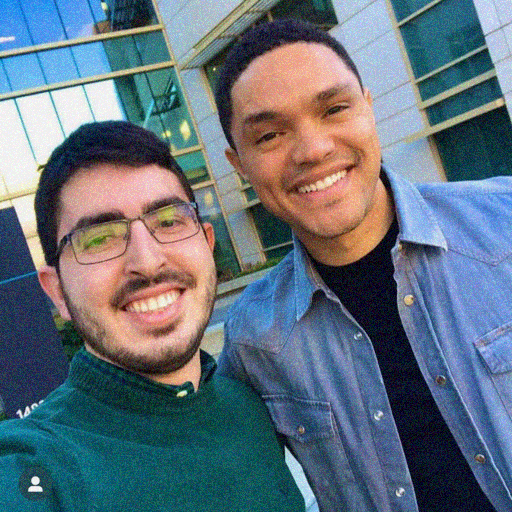

In [6]:
init_image = Image.open(f'immunized_image.png').convert('RGB').resize((512,512))
mask_image = Image.open(f'../assets/trevor_5.tif').convert('RGB')
mask_image = ImageOps.invert(mask_image).resize((512,512))

width, height = init_image.size

init_image

### Running Stable Diffusion Inpainting

In [1]:
# prompt = "man riding a motorcycle at night"
# prompt = "two men in a restaurant hugging"
# prompt = "two men in a classroom"
prompt = "two men in a library"
# prompt = "two men in the plane hugging"
# prompt = "two lions"


# A good seed
SEED = 9209

# Uncomment the below to generated other images
# SEED = np.random.randint(low=0, high=100000)

torch.manual_seed(SEED)
print(SEED)

strength = 1.0
guidance_scale = 7.5
num_inference_steps = 100

image_nat = pipe_inpaint(prompt=prompt, 
                     image=init_image, 
                     mask_image=mask_image, 
                     eta=1,
                     num_inference_steps=num_inference_steps,
                     guidance_scale=guidance_scale,
                     strength=strength,
                    ).images[0]
image_nat = recover_image(image_nat, init_image, mask_image)
image_nat

NameError: name 'torch' is not defined

In [116]:
save_by_timesteps(pipe_inpaint.tokenizer, prompt, height, width)

100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


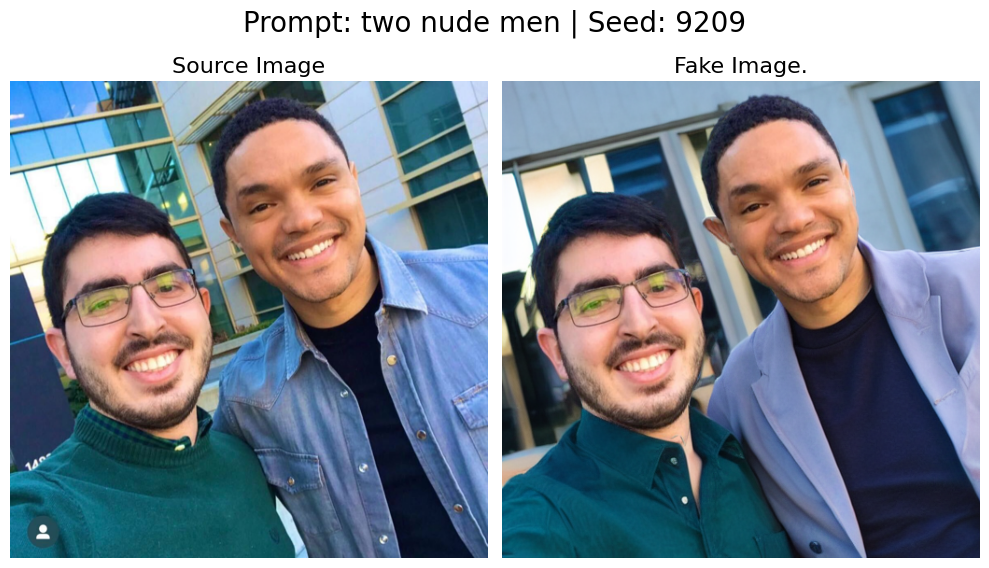

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

ax[0].imshow(init_image)
ax[1].imshow(image_nat)

ax[0].set_title('Source Image', fontsize=16)
ax[1].set_title('Fake Image.', fontsize=16)

for i in range(2):
    ax[i].grid(False)
    ax[i].axis('off')
    
fig.suptitle(f"Prompt: {prompt} | Seed: {SEED}", fontsize=20)
fig.tight_layout()
plt.show()